In [125]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
import pickle
#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# PIL - Image
from PIL import Image
from skimage.io import imread

# Keras 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report


# Problem Description and Data
This Kaggle competition is a binary image classification problem where I will identify metastatic cancer in small image patches taken from larger digital pathology scans. I will implement a CNN (Convultional Neural Network) to label new image scans to determine the presence of metastasis cancer.

## Description 
Create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset.
- Removed duplicates from dataset 
- PCam packs metastasis (cancer growth) detection into binary image classification tasks


## Dataset 
- Training Data Size - 22,025

- Test Data Size - 57,458

#### About the dataset
- Large number of small pathology images to classify. 
- Files are named with an image id. 
- The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. 
    - A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. 
- Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.
- No duplicates ( Original PCam Dataset had duplicates from sampling, but kaggle dataset doesn't contain duplicates)


# EDA 

In [3]:
# Locatations of file paths
training_path = 'histopathologic-cancer-detection/train/'
testing_path = 'histopathologic-cancer-detection/test/'

In [4]:
# Explain Data Set Sizes
training_size = len(os.listdir('histopathologic-cancer-detection/train/'))
test_size = len(os.listdir('histopathologic-cancer-detection/test/'))
print(f"Training Data Folder Size -> {training_size}")
print(f"Test Data Folder Size -> {test_size}")

Training Data Folder Size -> 220025
Test Data Folder Size -> 57458


In [27]:
training_labels_df = pd.read_csv("histopathologic-cancer-detection/train_labels.csv")

print(training_labels_df[training_labels_df['id']=='6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0'])

                                             id  label
73751  6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0      0


We can see from the dataframe that there are 220025 rows with labels which correspond with the images count in the training folder

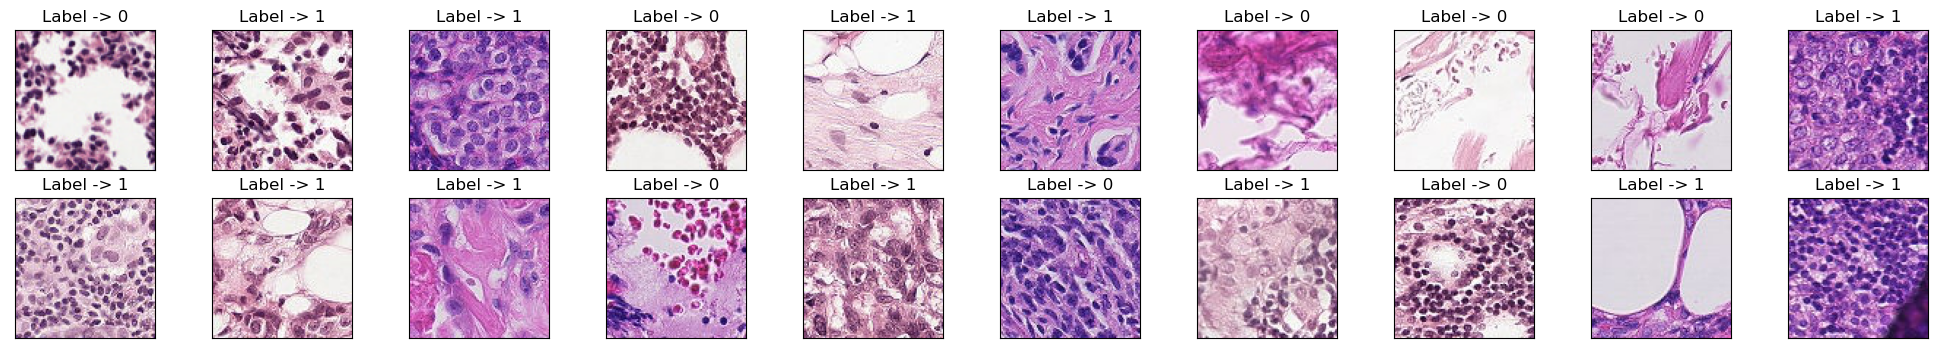

In [6]:
# Printing some of the images

fig = plt.figure(figsize=(25,4))
train_images = os.listdir(training_path)
for index, img in enumerate(np.random.choice(train_images, 20)):
    ax = fig.add_subplot(2, 
                         20//2, 
                         index+1, 
                         xticks=[], 
                         yticks=[])
    
    image = Image.open(training_path + img)

    plt.imshow(image)

    label = training_labels_df.loc[training_labels_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label -> {label}')


On initial inspection, I can't clearly determine which features from the cancer slides compared to the non cancer slides are what indicates the precence of metastatic cancer. I will further explore the data 

# ETL Data for Model

In [7]:
print(os.getcwd())


/Users/shawn/Documents/Masters in Data Science/Spring 2024/Deep Learning /Cancer Detection Histopathological


In [21]:
df = pd.DataFrame({'path' : glob(os.path.join(training_path,'*.tif'))})
# Get ID value for file and join on labels for training data to indicate which files assoc. with what labels
df['id'] = df.path.map(lambda x:x.split('/')[2].split(".")[0])

data_df = df.merge(training_labels_df, on='id')

data_df


,path,id,label
0,histopathologic-cancer-detection/train/f0c2a0b...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0,0
1,histopathologic-cancer-detection/train/99ef485...,99ef485f205645918613cd04281098daa7c17819,1
2,histopathologic-cancer-detection/train/e2612e1...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb,1
3,histopathologic-cancer-detection/train/6d1bb57...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0,0
4,histopathologic-cancer-detection/train/9c043ab...,9c043ab2adadfeb758c71d21432fccd3e43565c0,1
...,...,...,...
220020,histopathologic-cancer-detection/train/7a5f23a...,7a5f23a002018cd828cc5e8df89de79850d01050,1
220021,histopathologic-cancer-detection/train/7cd369c...,7cd369c04a37c9da20bbfe1bcba2cfad754fc100,1
220022,histopathologic-cancer-detection/train/b21c0dc...,b21c0dc5ba97639f3b5c62ffe00364cfb0c11b40,0
220023,histopathologic-cancer-detection/train/d16dbda...,d16dbdaf3b5cea4b5f6629e2a487f0e01075ba58,0


#### I ran into training issues and after research and studying other projects there are two training images that causes issues with the training processes that need to be removed


In [29]:
data_df = data_df[data_df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
data_df = data_df[data_df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

In [30]:
data_df

,path,id,label
0,histopathologic-cancer-detection/train/f0c2a0b...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0,0
1,histopathologic-cancer-detection/train/99ef485...,99ef485f205645918613cd04281098daa7c17819,1
2,histopathologic-cancer-detection/train/e2612e1...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb,1
3,histopathologic-cancer-detection/train/6d1bb57...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0,0
4,histopathologic-cancer-detection/train/9c043ab...,9c043ab2adadfeb758c71d21432fccd3e43565c0,1
...,...,...,...
220020,histopathologic-cancer-detection/train/7a5f23a...,7a5f23a002018cd828cc5e8df89de79850d01050,1
220021,histopathologic-cancer-detection/train/7cd369c...,7cd369c04a37c9da20bbfe1bcba2cfad754fc100,1
220022,histopathologic-cancer-detection/train/b21c0dc...,b21c0dc5ba97639f3b5c62ffe00364cfb0c11b40,0
220023,histopathologic-cancer-detection/train/d16dbda...,d16dbdaf3b5cea4b5f6629e2a487f0e01075ba58,0


# Training Data Setup - Train/Test ETL

In [64]:
# Take a sample of 80000 of each labeled value in order to get an equal sample size
sample_size = 80000

no_cancer_labels_df = data_df[data_df['label'] == 0].sample(sample_size, random_state=16)

cancer_labels_df = data_df[data_df['label'] == 1].sample(sample_size, random_state=16)

data_sampled_df = shuffle(pd.concat([no_cancer_labels_df,cancer_labels_df], axis=0).reset_index(drop=True))

data_sampled_df

,path,id,label
44331,histopathologic-cancer-detection/train/63ece49...,63ece49ce76901aa0dea3088ef1cb7b6ada4f405,0
131274,histopathologic-cancer-detection/train/74c9bc1...,74c9bc1a1211bc2dff1deb25a0dada101c8a5c62,1
134041,histopathologic-cancer-detection/train/98f471e...,98f471edc5b88009b21418e45415ec39e27e1727,1
32883,histopathologic-cancer-detection/train/6ba1a4b...,6ba1a4bbe56f9947ba576ffbaf0f7ffb47d3d8b0,0
54757,histopathologic-cancer-detection/train/b39e4fc...,b39e4fc42a6bc0cc2f203cd9d97822539bf823c5,0
...,...,...,...
49349,histopathologic-cancer-detection/train/f7ee909...,f7ee909ca1f3815a3ee17d7e478488fbe4c9215f,0
51093,histopathologic-cancer-detection/train/23708f3...,23708f36e616944c6e8481951be8e983915ddf46,0
98476,histopathologic-cancer-detection/train/d644a41...,d644a415b856fe17b9379e25dfed8e1821e8e0bf,1
106605,histopathologic-cancer-detection/train/11b1e47...,11b1e47f3dbc9f8276a3a83059caaa5548fd3024,1


In [34]:
y = data_sampled_df['label']

df_train, df_test = train_test_split(data_sampled_df, test_size=0.10,
                                     random_state=16, stratify=y)


In [40]:
train_data_path = 'model/train'
valid_data_path =  'model/valid'

for folder in [train_data_path, valid_data_path]:
    for subfolder in ['0','1']:
        os.makedirs(os.path.join(folder, subfolder))


In [43]:
data_sampled_df.set_index('id', inplace=True)
data_sampled_df

,path,label
id,,
f2d5f09742a60b3f8bbae9f214742b21bfa3ebde,histopathologic-cancer-detection/train/f2d5f09...,1
4f9b12f32255ff050b02793e70d52e8b2f0af507,histopathologic-cancer-detection/train/4f9b12f...,0
adc7a68e01554c7011fe1cda2a2066c8571d96bd,histopathologic-cancer-detection/train/adc7a68...,1
5d7b8d31e4b31e843301700c9d48ce282a21de67,histopathologic-cancer-detection/train/5d7b8d3...,0
99e5f48d6504c9904c7a29b2d4d90546a6112564,histopathologic-cancer-detection/train/99e5f48...,1
...,...,...
34fce040edd0d9a5e218511e1980f11fb434d8b3,histopathologic-cancer-detection/train/34fce04...,1
864c19cabe5ec1312fa4ab4ed68398bf4253542d,histopathologic-cancer-detection/train/864c19c...,0
c9c7ef7787ddb518b76d49602e8b107c9930c374,histopathologic-cancer-detection/train/c9c7ef7...,0


In [45]:

for images in df_train['id'].values:
    file_name = images + '.tif'
    label = str(data_sampled_df.loc[images,'label'])

    source = os.path.join(training_path,file_name)
    destination = os.path.join(train_data_path, label, file_name)
    shutil.copyfile(source, destination)

In [46]:

for images in df_test['id'].values:
    file_name = images + '.tif'
    label = str(data_sampled_df.loc[images,'label'])

    source = os.path.join(training_path,file_name)
    destination = os.path.join(valid_data_path, label, file_name)
    shutil.copyfile(source, destination)


In [62]:
print(len(os.listdir('model/train/0')))
print(len(os.listdir('model/train/1')))

print(len(os.listdir('model/valid/0')))
print(len(os.listdir('model/valid/1')))

72000
72000
8000
8000


In [63]:
from keras.preprocessing.image import ImageDataGenerator

image_size = 96

train_samp_num = len(df_train)
print(train_samp_num)
test_samp_num = len(df_test)
print(test_samp_num)


train_batch_size = 32
test_batch_size = 32

train_steps = np.ceil(train_samp_num/ train_batch_size)
test_steps = np.ceil(test_samp_num/ test_batch_size)


144000
16000


In [104]:
# Create image geneartors
data_generator = ImageDataGenerator(preprocessing_function=
                                   lambda x: (x-x.mean()) / x.std() if x.std() > 0 else x, 
                                horizontal_flip=True,
                                 vertical_flip=True )

train_generator = data_generator.flow_from_directory(train_data_path, target_size=(96,96),
                                               batch_size=test_batch_size,
                                               class_mode='binary')
test_generator = data_generator.flow_from_directory(valid_data_path, target_size=(96,96),
                                               batch_size=test_batch_size,
                                               class_mode='binary',
                                               shuffle=False)



Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


# Model

**The model will have the following design:**
- Input Image 
- Convolutions
    - 3 x per each filter
        - Convolution -> Pooling -> Dropout 
- Flatten
- Dense Layer
- Dropout
- Output Classification 


In [65]:
kernel = (3,3)
pool_size = (2,2)


filter_1 = 32
filter_2 = 64
filter_3 = 128

In [68]:
#Model

model = Sequential()

# First Filter Layer
model.add(Conv2D(filter_1, kernel, activation='relu', input_shape=(96,96,3)))
model.add(Conv2D(filter_1,kernel, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.3))

#Second Filter Layer
model.add(Conv2D(filter_2, kernel, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filter_2, kernel, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.3))

#Third Filter Layer
model.add(Conv2D(filter_3, kernel, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filter_3, kernel, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.3))

#Flatten
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(Adam(0.01), loss='binary_crossentropy',metrics=['accuracy'])


# Training Model

In [72]:
early_stopper = EarlyStopping(monitor='val_loss', patience=1, verbose=1, 
                             restore_best_weights=True)

reducution = ReduceLROnPlateau(monitor='val_loss', patience=1,verbose=1,factor=0.1)

model_fit = model.fit_generator(train_generator, steps_per_epoch=train_steps,
                                validation_data=test_generator,
                                validation_steps=test_steps,
                                epochs=13,
                                callbacks=[reducution, early_stopper])


Epoch 1/13


/var/folders/8n/k4ymc8nx1q5420j8bz49s4440000gn/T/ipykernel_9518/858708716.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_fit = model.fit_generator(train_generator, steps_per_epoch=train_steps,


4500/4500 [==============================] - 1738s 386ms/step - loss: 0.4131 - accuracy: 0.8183 - val_loss: 0.2311 - val_accuracy: 0.9180 - lr: 0.0100
Epoch 2/13
4500/4500 [==============================] - 2384s 530ms/step - loss: 0.3432 - accuracy: 0.8555 - val_loss: 0.1485 - val_accuracy: 0.9520 - lr: 0.0100
Epoch 3/13
4500/4500 [==============================] - 3713s 825ms/step - loss: 0.2984 - accuracy: 0.8778 - val_loss: 0.1404 - val_accuracy: 0.9560 - lr: 0.0100
Epoch 4/13
4500/4500 [==============================] - 4134s 919ms/step - loss: 0.2734 - accuracy: 0.8901 - val_loss: 0.0666 - val_accuracy: 0.9820 - lr: 0.0100
Epoch 5/13
4500/4500 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.9000
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Restoring model weights from the end of the best epoch: 4.
4500/4500 [==============================] - 3626s 806ms/step - loss: 0.2559 - accuracy: 0.9000 - val_loss: 0.0843 - val_accuracy:

In [74]:
model_pickle_file = 'cancer_detection_model.pkl'

with open(model_pickle_file, 'wb') as file:
    pickle.dump(model_fit, file)

INFO:tensorflow:Assets written to: ram://a957a1de-74dd-4019-b5e1-ea1bb7c08f11/assets


INFO:tensorflow:Assets written to: ram://a957a1de-74dd-4019-b5e1-ea1bb7c08f11/assets


In [76]:
model.metrics_names

['loss', 'accuracy']

In [80]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_predict = model.predict_generator(test_generator, steps=len(df_test))

false_positive_score, true_positive_score, threshold = roc_curve(test_generator.classes, y_predict)

#Area under Curve for ROC Curve
auc_roc = auc(false_positive_score,true_positive_score)

auc_roc

/var/folders/8n/k4ymc8nx1q5420j8bz49s4440000gn/T/ipykernel_9518/710119939.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_predict = model.predict_generator(test_generator, steps=len(df_test))


0.9416297421875

In [130]:
from sklearn.metrics import roc_auc_score
y_true = test_generator.classes
roc_auc_score(y_true, y_predict)

0.9416297421875

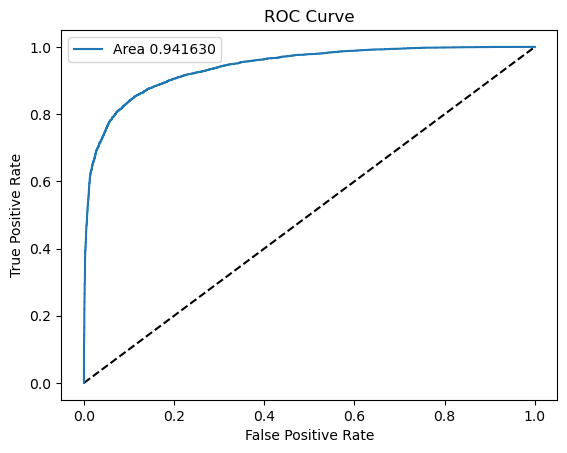

In [82]:
plt.figure()
plt.plot([0,1],[0,1],'k--')
plt.plot(false_positive_score,true_positive_score, label='Area {:3f}'.format(auc_roc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('ROC Curve')
plt.show()

# Testing on new data
**Steps:**
- Load data into testing directory
- Create Generator
- Make prediction on test images
- Validate solutions

In [83]:
#Create Test Directory
os.mkdir('test_directory')

test_images = os.path.join('test_directory', 'test_images')
os.mkdir(test_images)

In [86]:
test_list = os.listdir(testing_path)

for image in test_list:

    filename = image

    source = os.path.join(testing_path,filename)
    destination = os.path.join(test_images,filename)

    shutil.copy(source,destination)

In [87]:
len(os.listdir('test_directory/test_images'))

57458

In [121]:
submission = pd.DataFrame()
test_files= glob(os.path.join(testing_path,'*.tif'))
batching = 5000

max_index=len(test_files)

test_files
for index in range(0,max_index,batching):

    new_test_df = pd.DataFrame({"path": test_files[index:index+batching]})
    new_test_df['id'] = new_test_df.path.map(lambda x: x.split('/')[2].split(".")[0])


    new_test_df['image'] = new_test_df['path'].map(imread)

    K_test = np.stack(new_test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    new_test_df['label'] = predictions
    submission = pd.concat([submission, new_test_df[["id", "label"]]])
submission.head()


77/77 [==============================] - 9s 115ms/step


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0.176430
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0.297797
2,19709bec800f372d0b1d085da6933dd3ef108846,0.032867
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0.009489
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0.007115


In [124]:
submission.to_csv("submission.csv", index = False, header = True)

# Conculsion 

Through this project I implemented a convolution nueral network to label if an input image of medical image scans. Through this project I used a 3 layer convolution neural network to process the train images, then make predicitons. My model had a 94% accuracy score and through kaggle and with the test data I achieved a public and private score of 0.8409 and 0.8495 respectively. I could further this score by hypertuning the epochs, batch sizes and filter/ model architecure redesign or refactoring. Due to time constraints I couldn't further explore hypertuning to achieve a higher score for this competition 

# Resources

https://towardsdatascience.com/understanding-convolutions-and-pooling-in-neural-networks-a-simple-explanation-885a2d78f211


https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

https://medium.com/advanced-deep-learning/cnn-operation-with-2-kernels-resulting-in-2-feature-mapsunderstanding-the-convolutional-filter-c4aad26cf32#:~:text=Convolutional%20filters%2C%20also%20called%20kernels,edges%2C%20corners%2C%20or%20textures.

